In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 32
num_classes = 2  # Assuming two classes: cancerous and non-cancerous
learning_rate = 0.001
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define transformations for the training and validation sets
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Train_Test_Split/train_val', transform=transform_train)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Train_Test_Split/test', transform=transform_val)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Load the MobileNetV2 model
model = mobilenet_v2(pretrained=True)

# Modify the final fully connected layer to match the number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 81.4MB/s]


In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/162], Loss: 0.6985
Epoch [2/5], Step [100/162], Loss: 0.5321
Epoch [3/5], Step [100/162], Loss: 0.3881
Epoch [4/5], Step [100/162], Loss: 0.2339
Epoch [5/5], Step [100/162], Loss: 0.4557


Accuracy of the network: 92.38 %


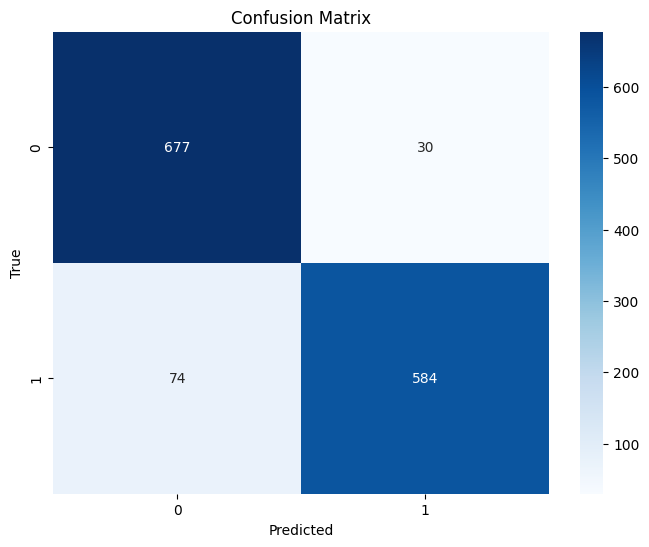

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       707
           1       0.95      0.89      0.92       658

    accuracy                           0.92      1365
   macro avg       0.93      0.92      0.92      1365
weighted avg       0.93      0.92      0.92      1365



In [ ]:
# Evaluation function
def evaluate_model(loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy of the network: {accuracy:.2f} %')

    # Confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred))

# Evaluate on validation set
evaluate_model(val_loader)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/5], Step [100/162], Loss: 0.3352

Evaluating after epoch 1...
Accuracy of the network: 92.82 %


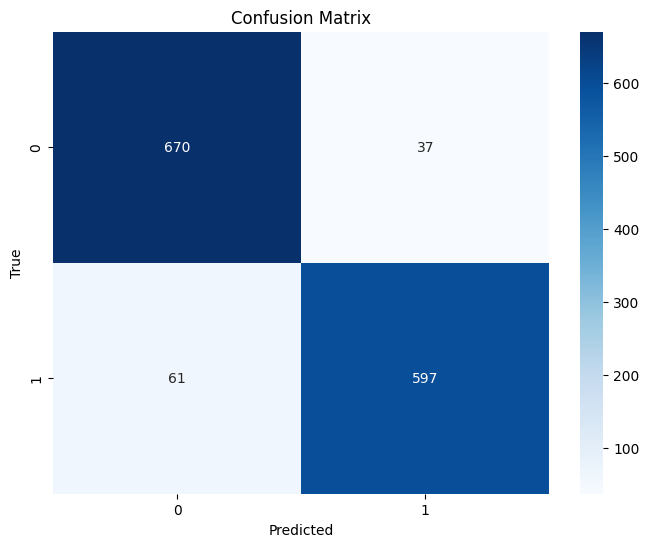

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       707
           1       0.94      0.91      0.92       658

    accuracy                           0.93      1365
   macro avg       0.93      0.93      0.93      1365
weighted avg       0.93      0.93      0.93      1365



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [2/5], Step [100/162], Loss: 0.1685

Evaluating after epoch 2...
Accuracy of the network: 93.63 %


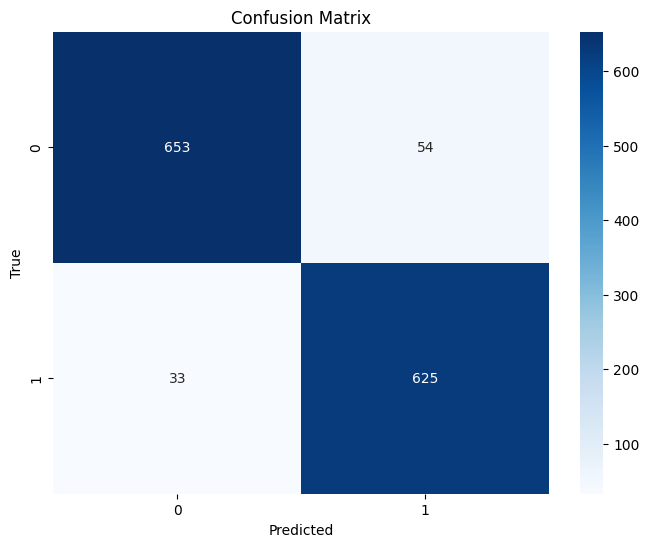

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       707
           1       0.92      0.95      0.93       658

    accuracy                           0.94      1365
   macro avg       0.94      0.94      0.94      1365
weighted avg       0.94      0.94      0.94      1365



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [3/5], Step [100/162], Loss: 0.1756

Evaluating after epoch 3...
Accuracy of the network: 93.77 %


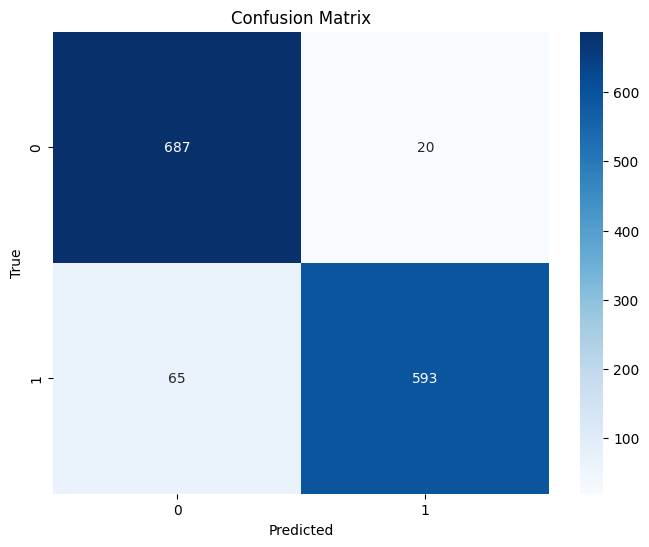

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       707
           1       0.97      0.90      0.93       658

    accuracy                           0.94      1365
   macro avg       0.94      0.94      0.94      1365
weighted avg       0.94      0.94      0.94      1365



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [4/5], Step [100/162], Loss: 0.1972

Evaluating after epoch 4...
Accuracy of the network: 91.72 %


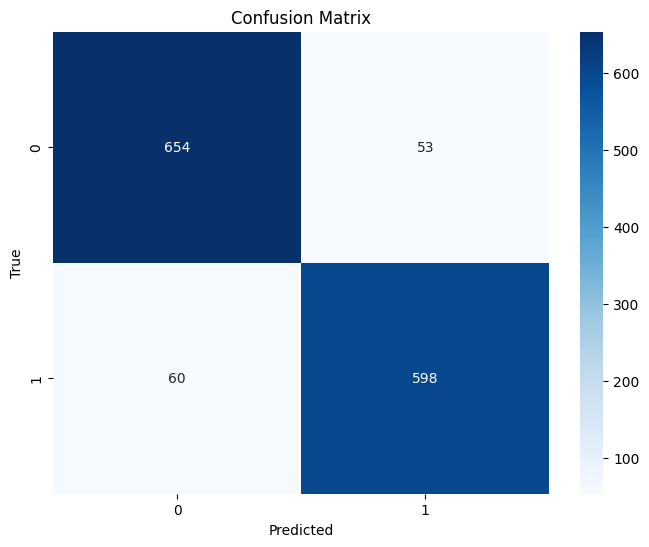

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       707
           1       0.92      0.91      0.91       658

    accuracy                           0.92      1365
   macro avg       0.92      0.92      0.92      1365
weighted avg       0.92      0.92      0.92      1365



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [5/5], Step [100/162], Loss: 0.2088

Evaluating after epoch 5...
Accuracy of the network: 93.33 %


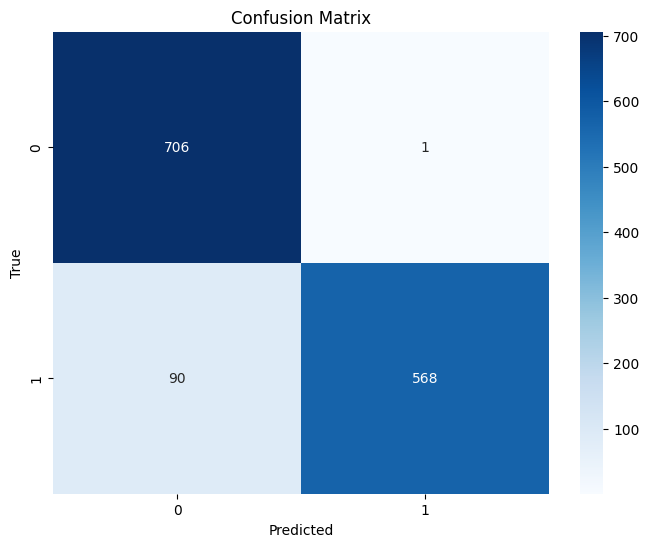

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       707
           1       1.00      0.86      0.93       658

    accuracy                           0.93      1365
   macro avg       0.94      0.93      0.93      1365
weighted avg       0.94      0.93      0.93      1365



In [ ]:
# Training and evaluation process
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Evaluate on validation set after each epoch
    print(f'\nEvaluating after epoch {epoch+1}...')
    evaluate_model(val_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/5], Step [100/162], Loss: 0.2440

Evaluating after epoch 1...
Accuracy of the network: 95.46 %
Epoch [2/5], Step [100/162], Loss: 0.3401

Evaluating after epoch 2...
Accuracy of the network: 96.70 %
Epoch [3/5], Step [100/162], Loss: 0.1058

Evaluating after epoch 3...
Accuracy of the network: 94.65 %
Epoch [4/5], Step [100/162], Loss: 0.1559

Evaluating after epoch 4...
Accuracy of the network: 94.07 %
Epoch [5/5], Step [100/162], Loss: 0.0939

Evaluating after epoch 5...
Accuracy of the network: 96.19 %


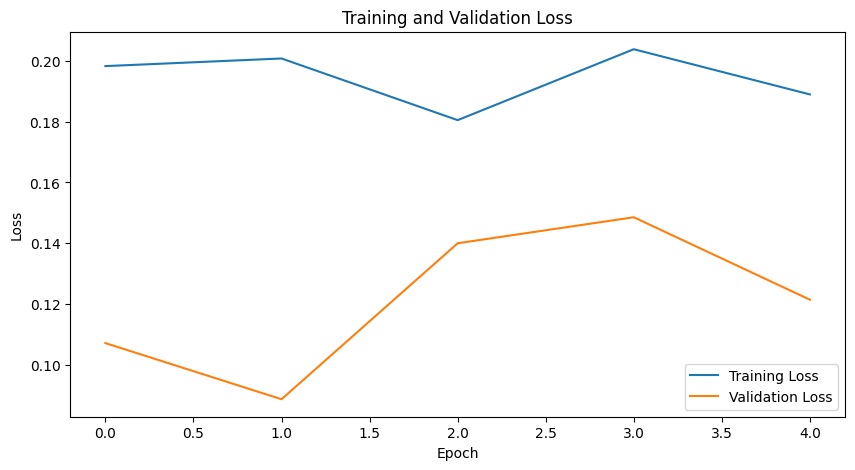

In [ ]:
import matplotlib.pyplot as plt

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training and evaluation process
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Average training loss for the epoch
    train_losses.append(running_loss / len(train_loader))

    # Evaluate on validation set after each epoch
    print(f'\nEvaluating after epoch {epoch+1}...')
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy of the network: {accuracy:.2f} %')

    # Average validation loss for the epoch
    val_losses.append(val_loss / len(val_loader))

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


NameError: name 'train_acc_history' is not defined

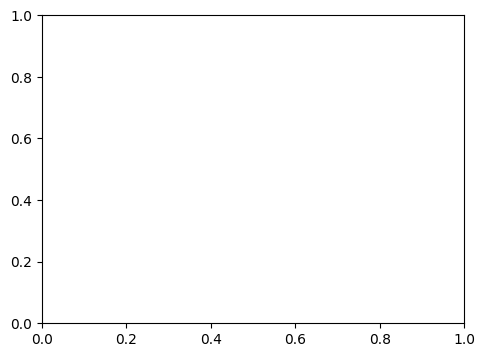

In [ ]:
# Plot accuracy and loss history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Comparison')

plt.show()

NameError: name 'train_loss_history' is not defined

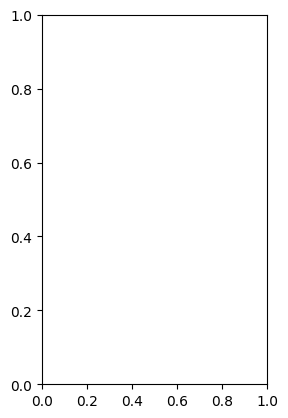

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison')
plt.show()

In [ ]:
# Evaluate model on validation set and print classification report
def evaluate_model(loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy of the network: {accuracy:.2f} %')

    # Confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification report
    print(classification_report(y_true, y_pred))

# Evaluate on validation set
evaluate_model(val_loader)

KeyboardInterrupt: 